# Пайплайн для выделения лучших кропов по текстовому запросу ViLD -> Clip -> Annoy

Все расчеты ниже получены по valid выборке датасета LVIS

* Применяем модель ViLD MaskRCNN к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

In [123]:
#!c1.8
import tensorflow.compat.v1 as tf

tf.__version__

'2.7.1'

In [124]:
#!c1.8
from assh_utils import get_iou, load_json, nms

In [125]:
#!c1.8
import os

root = "/home/jupyter/mnt/s3/asciishell-fsod/LVIS/"
js = load_json("/home/jupyter/mnt/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [126]:
#!c1.8
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [127]:
#!c1.8
1+1

2

## Применяем модель ViLD MaskRCNN с NMS
Сохраняем датафрейм с картинками и соответствующими кропами.

In [5]:
#!g1.1
saved_model_dir = "/home/jupyter/mnt/s3/asciishell-fsod/image_path_v2"
session = tf.Session(graph=tf.Graph())
_ = tf.saved_model.loader.load(session, ["serve"], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /home/jupyter/mnt/s3/asciishell-fsod/image_path_v2/variables/variables


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: session
  warnings.warn(message)


In [6]:
#!g1.1
from collections import defaultdict

nms_threshold = 0.6
min_rpn_score_thresh = 0.9
min_box_area = 220
max_boxes_to_draw = 200

results = defaultdict(list)
embeddings = []

for name in tqdm(images):
    roi_boxes, roi_scores, detection_boxes, visual_features, image_info = session.run(
        ["RoiBoxes:0", "RoiScores:0", "2ndStageBoxes:0", 'VisualFeatOutputs:0', "ImageInfo:0"],
        feed_dict={
            "Placeholder:0": [
                name,
            ]
        },
    )

    roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
    roi_scores = np.squeeze(roi_scores, axis=0)
    detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
    visual_features = np.squeeze(visual_features, axis=0)
    
    image_info = np.squeeze(image_info, axis=0)  # obtain image info
    image_scale = np.tile(image_info[2:3, :], (1, 2))

    rescaled_detection_boxes = detection_boxes / image_scale  # rescale
    # Apply non-maximum suppression to detected boxes with nms threshold.
    nmsed_indices = nms(detection_boxes, roi_scores, thresh=nms_threshold)

    # Compute RPN box size.
    box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (
        rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1]
    )

    # Filter out invalid rois (nmsed rois)
    valid_indices = np.where(
        np.logical_and(
            np.isin(np.arange(len(roi_scores), dtype=np.int32), nmsed_indices),
            np.logical_and(
                np.logical_not(np.all(roi_boxes == 0.0, axis=-1)),
                np.logical_and(roi_scores >= min_rpn_score_thresh, box_sizes > min_box_area),
            ),
        )
    )[0]

    detection_roi_scores = roi_scores[valid_indices]
    rescaled_detection_boxes = rescaled_detection_boxes[valid_indices]
    visual_features = visual_features[valid_indices]


    rescaled_detection_boxes = rescaled_detection_boxes.round().astype(np.int32)
    valid_indices_dedup = []
    dup_set = set()
    for i, (ymin, xmin, ymax, xmax) in enumerate(rescaled_detection_boxes):
        if np.abs(xmin - xmax) <= 5 or np.abs(ymin - ymax) <= 5:
            continue
        if (ymin, xmin, ymax, xmax) in valid_indices_dedup:
            continue
        dup_set.add((ymin, xmin, ymax, xmax))
        valid_indices_dedup.append(i)
        
    detection_roi_scores = detection_roi_scores[valid_indices_dedup][:max_boxes_to_draw, ...]
    rescaled_detection_boxes = rescaled_detection_boxes[valid_indices_dedup][:max_boxes_to_draw, ...]
    visual_features = visual_features[valid_indices_dedup][:max_boxes_to_draw, ...]

    ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)
    
    results["image"].extend([name] * len(detection_roi_scores))
    results["xmin"].extend(xmin.reshape(1, -1)[0])
    results["ymin"].extend(ymin.reshape(1, -1)[0])
    results["xmax"].extend(xmax.reshape(1, -1)[0])
    results["ymax"].extend(ymax.reshape(1, -1)[0])
    results["roi_scores"].extend(detection_roi_scores)
    embeddings.extend(visual_features)
results = pd.DataFrame(results)
embeddings = np.stack(embeddings)
results.to_pickle(f"/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_vild.pkl.zip")
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_vild_emb.npy", embeddings)

100%|██████████| 19809/19809 [1:10:19<00:00,  4.69it/s]
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: session
  warnings.warn(message)


In [118]:
# plt.figure(figsize=(18, 18), facecolor="w")
# image = cv2.imread(name, cv2.IMREAD_COLOR)
# assert image is not None
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# for _, row in results.iterrows():
#     image = cv2.rectangle(
#         image,
#         (row["xmin"], row["ymin"]),
#         (row["xmax"], row["ymax"]),
#         (255, 0, 0),
#         2,
#     )
# plt.imshow(image)

## Получим эмбеддинг для определения каждой категории датасета LVIS
Сохраним категорию и соответствующий ей эмбеддинг.

In [5]:
def get_vector_text(x):
    text_inputs = torch.cat([clip.tokenize(x)]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].cpu().numpy()


def get_vector_image(x):
    img = PIL.Image.open(x)
    img.thumbnail((640, 640), PIL.Image.ANTIALIAS)
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()

In [8]:
categories_emb = []
categories = []
for category in tqdm(js["categories"]):
    categories_emb.append(get_vector_text(category["def"]))
    categories.append(category)
categories_emb = np.stack(categories_emb)
categories = pd.DataFrame(categories)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy", categories_emb)
categories.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [128]:
#!c1.8
categories_emb = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [135]:
#!c1.8
embeddings = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_vild_emb.npy")
images = pd.read_pickle(f"/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_vild.pkl.zip")

## Для эмбеддинга каждой категории найдем n ближайших соседей из эмбеддингов кропов

In [129]:
#!c1.8
def cos_sim_matrix(a, b):
    return np.dot(a, b) / np.linalg.norm(b)

def get_ns_by_vector(vec, n):
    vec = vec.astype(np.float32)
    dist = cos_sim_matrix(embeddings, vec)
    idx = np.argsort(dist)
    top_idx = idx[: -n - 1 : -1]
    return top_idx, dist

## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [136]:
#!c1.8
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = get_ns_by_vector(categories_emb[index], 30) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'roi_scores']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    
metrics = pd.DataFrame(metrics)
metrics.to_pickle('/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_vild_metrics_100.pkl.zip')

  0%|          | 0/1203 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/jupyter/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1203/1203 [04:51<00:00,  4.13it/s]


In [137]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [138]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,NaN,0,0.272688,0.996139,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,NaN,0,0.277334,0.988510,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,NaN,0,0.274537,0.992109,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,NaN,0,0.274599,0.994194,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,NaN,0,0.273453,0.994294,NaN,0.0


In [139]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
1717,344,cup,10,0.931796,0.986111,1.000000,8,0.286749,0.993255,0.881367,0.8
1082,217,carrot,10,0.786111,0.800000,0.800000,6,0.206971,0.994386,0.937384,0.6
5167,1034,sunflower,10,1.000000,0.680159,0.691270,6,0.194216,0.993560,0.907695,0.6
1707,342,cucumber,10,0.705159,0.976190,1.000000,6,0.212205,0.999026,0.935276,0.6
4782,957,shower_curtain,10,0.619286,0.392381,0.381270,5,0.176997,0.997597,0.930927,0.5
1172,235,chandelier,10,0.759524,0.460952,0.520000,5,0.243580,0.994217,0.907979,0.5
1147,230,cellular_telephone,10,0.654444,0.572222,0.583333,5,0.238969,0.993740,0.927168,0.5
432,87,bell_pepper,10,0.672619,0.476825,0.519286,5,0.229185,0.993925,0.926309,0.5
2222,445,fireplug,10,1.000000,0.619048,0.714286,5,0.236540,0.976578,0.972615,0.5
327,66,bath_towel,10,0.804167,0.792857,0.830357,4,0.231112,0.999298,0.933934,0.4


In [140]:
# не угадываем редкие объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,NaN,0,0.274537,0.992109,NaN,0.0
3987,798,piano,10,NaN,NaN,NaN,0,0.224626,0.989235,NaN,0.0
3982,797,phonograph_record,10,NaN,NaN,NaN,0,0.271619,0.976581,NaN,0.0
3977,796,phonebook,10,NaN,NaN,NaN,0,0.241594,0.987965,NaN,0.0
3972,795,pew_(church_bench),10,NaN,NaN,NaN,0,0.201273,0.965669,NaN,0.0
3967,794,pet,10,NaN,NaN,NaN,0,0.235171,0.977550,NaN,0.0
3957,792,persimmon,10,NaN,NaN,NaN,0,0.221319,0.982732,NaN,0.0
3992,799,pickle,10,NaN,NaN,NaN,0,0.221061,0.985175,NaN,0.0
3952,791,perfume,10,NaN,NaN,NaN,0,0.211439,0.992701,NaN,0.0
3942,789,pepper,10,NaN,NaN,NaN,0,0.256231,0.986583,NaN,0.0


In [141]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [142]:
# у нас много редких категорий и для них неправильно смотреть большое кол-во ближайших соседей
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [143]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [144]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [145]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(194, 0.11865443425076452)

In [146]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(286, 0.8746177370030581)

In [147]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.009174
5     0.140673
10    0.293578
20    0.620795
30    0.926606
Name: tp, dtype: float64

In [148]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.022222
5     0.072222
10    0.138889
20    0.266667
30    0.427778
Name: tp, dtype: float64

In [149]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.009174
5     0.055624
10    0.065105
20    0.075105
30    0.089862
Name: average_precision_conf, dtype: float64

In [150]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.009174
5     0.044589
10    0.053236
20    0.048769
30    0.049869
Name: average_precision_dist, dtype: float64

In [151]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.009174
5     0.049847
10    0.057401
20    0.054490
30    0.054597
Name: average_precision_multi, dtype: float64

In [152]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [153]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.8746177370030581

In [154]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.9388888888888889

In [155]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.022222
5     0.039815
10    0.035777
20    0.041814
30    0.043319
Name: average_precision_conf, dtype: float64

In [156]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.022222
5     0.023364
10    0.023449
20    0.024774
30    0.024040
Name: average_precision_dist, dtype: float64

In [157]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.022222
5     0.024907
10    0.024804
20    0.028266
30    0.027336
Name: average_precision_multi, dtype: float64

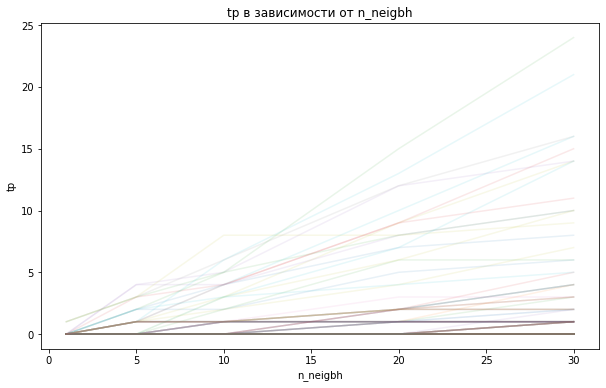

In [158]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [159]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.009174
5     0.028135
10    0.029358
20    0.031040
30    0.030887
Name: accuracy, dtype: float64

In [160]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.022222
5     0.014444
10    0.013889
20    0.013333
30    0.014259
Name: accuracy, dtype: float64

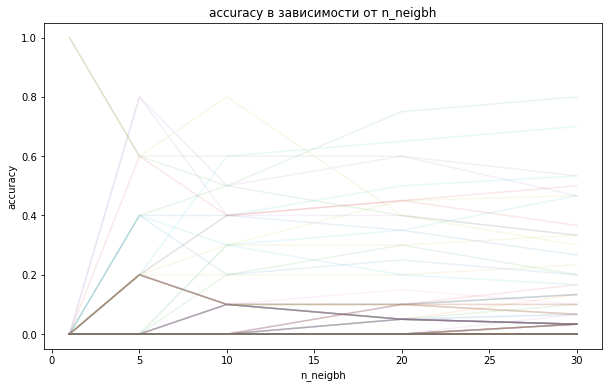

In [161]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

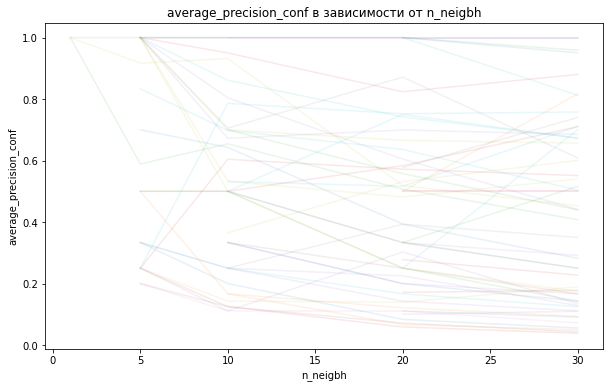

In [162]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

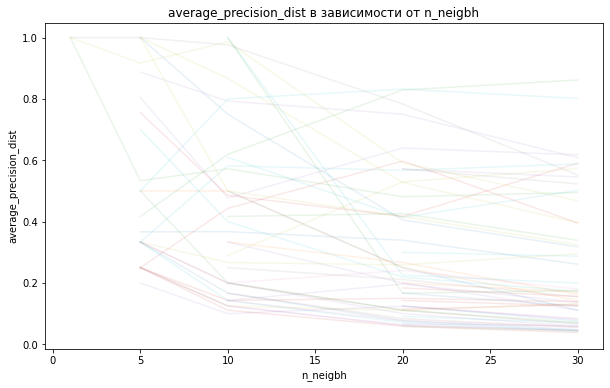

In [163]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

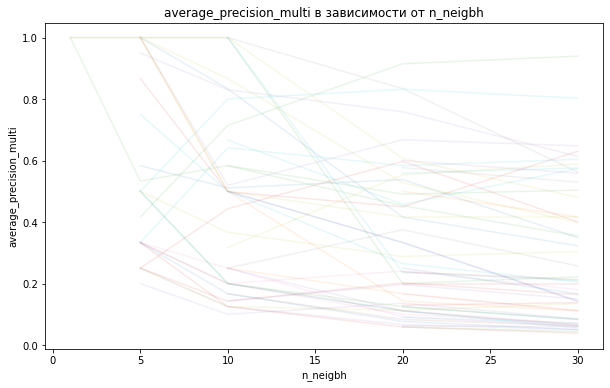

In [164]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

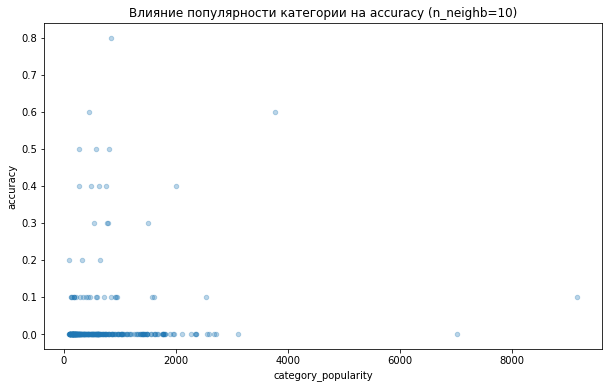

In [165]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

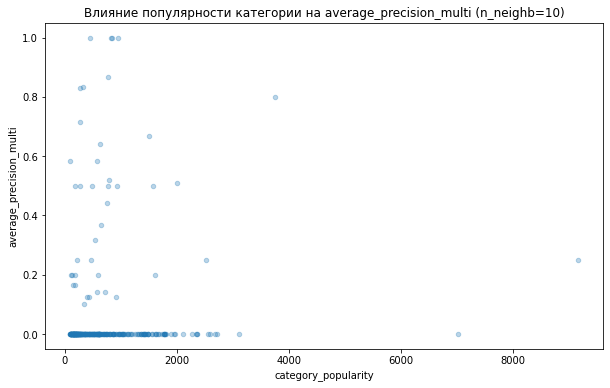

In [166]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

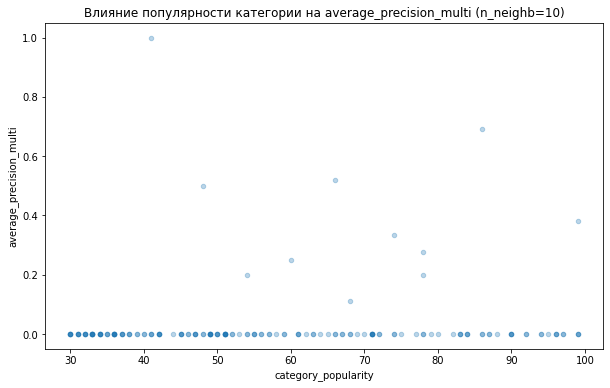

In [167]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

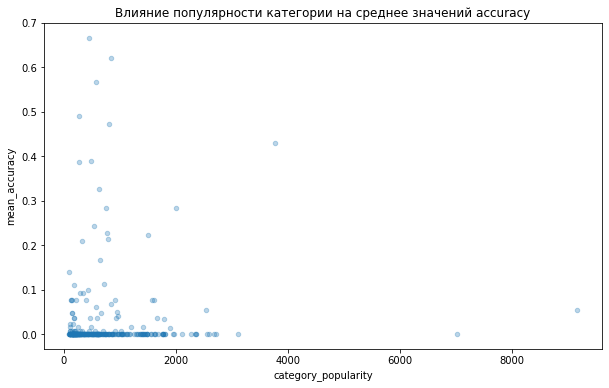

In [168]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

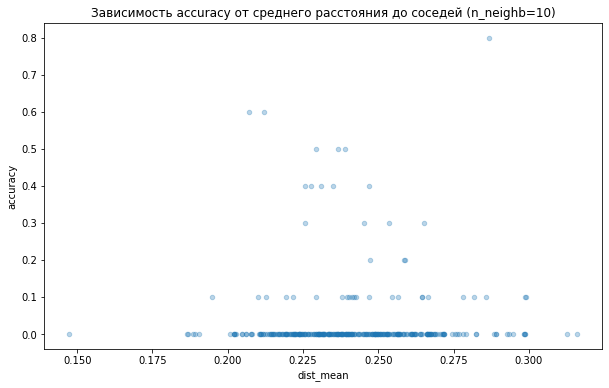

In [169]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [170]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
5772,1155,wall_socket,10,NaN,NaN,NaN,0,0.147410,0.974709,NaN,0.0
4357,872,raspberry,10,NaN,NaN,NaN,0,0.186545,0.991245,NaN,0.0
2002,401,duck,10,NaN,NaN,NaN,0,0.186843,0.999612,NaN,0.0
2567,514,green_bean,10,NaN,NaN,NaN,0,0.188526,0.986267,NaN,0.0
122,25,asparagus,10,NaN,NaN,NaN,0,0.189142,0.981370,NaN,0.0
1357,272,clock_tower,10,NaN,NaN,NaN,0,0.190359,0.999172,NaN,0.0
577,116,blueberry,10,0.5,0.142857,0.142857,1,0.194682,0.979803,0.916949,0.1
2262,453,flamingo,10,NaN,NaN,NaN,0,0.200911,0.999645,NaN,0.0
4827,966,ski_parka,10,NaN,NaN,NaN,0,0.202154,0.975345,NaN,0.0
3182,637,Lego,10,NaN,NaN,NaN,0,0.202217,0.992802,NaN,0.0


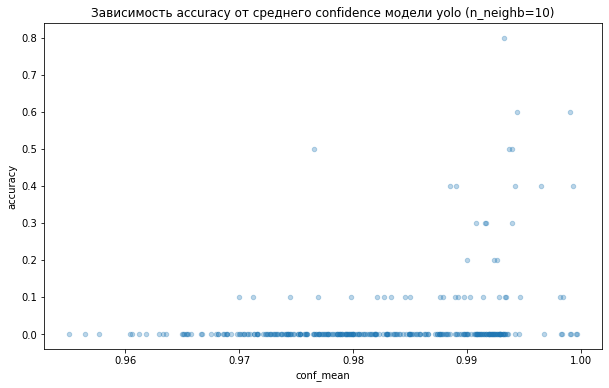

In [171]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

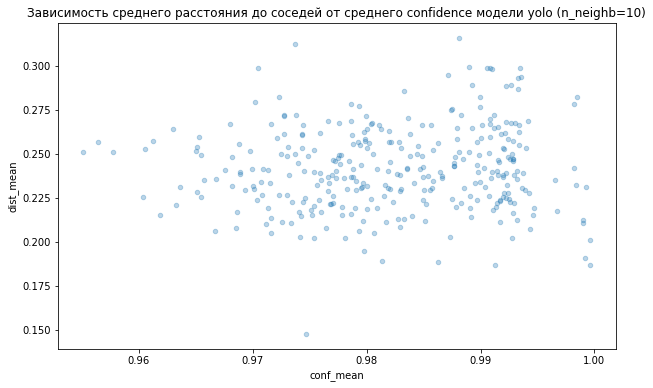

In [172]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

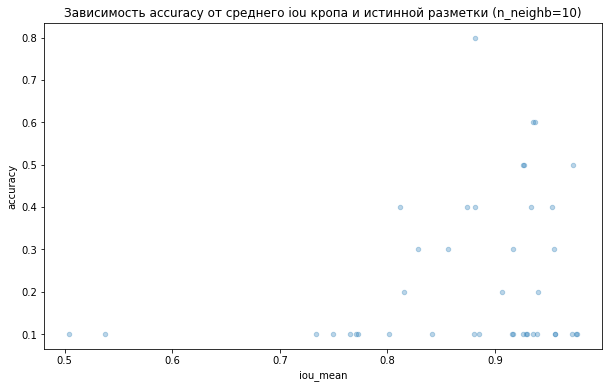

In [173]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()